# **IMPORTANDO BIBLIOTECAS**

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import os

# **IMPORTANDO IMAGENS P/ FAZER TESTES**

In [195]:
from google.colab import files
imagens = files.upload()
print("Importando imagens ...")

Saving sem_mask.jpeg to sem_mask (1).jpeg
Importando imagens ...


In [196]:
img = cv.imread("sem_mask.jpeg") # Lendo a imagem

In [53]:
type(img) # Python são escritos emcima da lib numpy

numpy.ndarray

In [15]:
# Os valores no opencv de uma imagem são carregados invertidos (BGR), 
# por isso precisamos fazer a conversão das cores p/ RGB
def exibir_img(image):
  img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img_rgb)

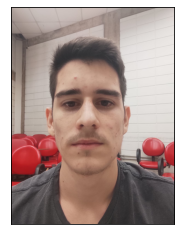

In [198]:
# Passando a imagem
exibir_img(img)

# **PRÉ-PROCESSAMENTO**

Será utilizado técnicas de processamento de imagens para identificação
das faces. Serão salvas em diretórios apenas as faces extraídas. 
Para diminuir a quantidade de ruídos em uma imagem, antes do treinamento da REDE NEURAL.


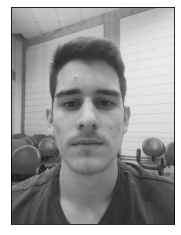

In [199]:
imagem_cinza = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
exibir_img(imagem_cinza)

O CascadeClassifier é uma implementação do algoritmo **VIOLA-JONES** para a detecção de objetos em Imagens

In [200]:
# Chamando o modelo de classificação
classificador = cv.CascadeClassifier(f'{cv.haarcascades}/haarcascade_frontalface_alt2.xml')

In [201]:
# É retornado coordenadas aonde contém as faces
faces = classificador.detectMultiScale(imagem_cinza)

In [202]:
img_copia = np.array(img)

In [203]:
for x,y,l,a in faces:
  cv.rectangle(img_copia, (x, y), (x+l, y+a), (0, 0, 255), 2)

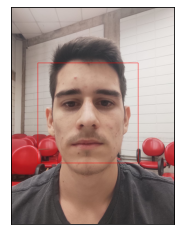

In [204]:
exibir_img(img_copia)

In [207]:
# Todas as faces serão guardadas em uma lista
faces_cortadas = list()

In [208]:
for x, y, l, a in faces:
  face = img[y:y+a, x:x+l]
  face = cv.resize(face, (160, 160))
  faces_cortadas.append(face)

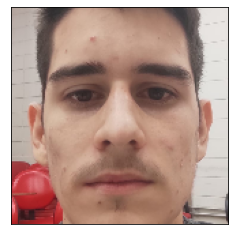

In [209]:
exibir_img(faces_cortadas[0])

In [210]:
def salvar_imagens(imagens, caminho):

  if not os.path.exists(caminho):
    os.mkdir(caminho)
  
  index = len(os.listdir(caminho))

  for imagem in imagens:
    cv.imwrite(f'{caminho}/{index}.jpg', imagem)
    index += 1

In [211]:
salvar_imagens(faces_cortadas, "/content/drive/MyDrive/data_set_faces/")

# **CRIANDO A REDE NEURAL P/ RECONHECIMENTO DO USO DE MÁSCARA**

In [2]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [63]:
def carregar_dataframe():
  
  dados = {
      "ARQUIVO" : [],
      "ROTULO" : [],
      "ALVO" : []
  }

  com_mascara = "/content/drive/MyDrive/data_set_faces/com_mascara"
  sem_mascara = "/content/drive/MyDrive/data_set_faces/sem_mascara"

  c_mascara = os.listdir(com_mascara)
  s_mascara = os.listdir(sem_mascara)

  for arquivo in c_mascara:
    dados["ARQUIVO"].append(f"{com_mascara}{os.sep}{arquivo}")
    dados["ROTULO"].append(f"Com mascara")
    dados["ALVO"].append(1)

  for arquivo in s_mascara:
    dados["ARQUIVO"].append(f"{sem_mascara}{os.sep}{arquivo}")
    dados["ROTULO"].append(f"Sem mascara")
    dados["ALVO"].append(0)

    dataFrame = pd.DataFrame(dados)

    return dataFrame

In [64]:
dados = carregar_dataframe()

In [65]:
dados.to_csv('/content/drive/MyDrive/data_set_faces/imagens.csv')

In [66]:
dados = pd.read_csv("/content/drive/MyDrive/data_set_faces/imagens.csv")

In [67]:
dados.head()

,Unnamed: 0,ARQUIVO,ROTULO,ALVO
0,0,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1
1,1,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1
2,2,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1
3,3,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1
4,4,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1


In [68]:
def ler_imagens(imagens):
  
  arquivos = imagens['ARQUIVO']
  imagens = list()
  
  for arquivo in arquivos:
    img = cv.imread(arquivo)
    
    if img is not None:
      img = cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten()
      imagens.append(img)

  dados["IMAGEM"] = imagens

In [ ]:
ler_imagens(dados)

In [73]:
dados.head()

,Unnamed: 0,ARQUIVO,ROTULO,ALVO,IMAGEM
0,0,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1,"[46, 45, 40, 43, 54, 72, 102, 124, 141, 150, 1..."
1,1,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1,"[119, 114, 109, 103, 99, 98, 96, 97, 101, 106,..."
2,2,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1,"[145, 146, 145, 143, 140, 138, 135, 132, 129, ..."
3,3,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1,"[93, 93, 93, 95, 97, 100, 104, 108, 112, 117, ..."
4,4,/content/drive/MyDrive/data_set_faces/com_masc...,Com mascara,1,"[13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 1..."


Separando um conjunto de dados para treino e outro para teste

In [75]:
x = list(dados['IMAGEM'])
y = list(dados['ALVO'])

In [143]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, train_size=0.60, random_state=5)

Utilizarei o método PCA para separar as características
das imagens e identicar o que esetão com mascaras e 
sem mascara.

In [144]:
pca = PCA(n_components=5)
pca.fit(x_treino)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [145]:
x_treino = pca.transform(x_treino)
x_teste = pca.transform(x_teste)

GRID SEARCH

In [146]:
parametro = {
    'n_neighbors' : [2, 3, 5, 11, 19, 23, 29],
    "weights" : ['uniform', 'distance'],
    "metric" : ['euclidean', 'manhattam', 'cosine', 'l1', 'l2']
}

In [147]:
# Algoritmo KNeighbors irá fazer a melhor escolha para o nosso modelo
knn = GridSearchCV(KNeighborsClassifier(), parametro)

In [148]:
knn.fit(x_treino, y_treino)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattam', 'cosine', 'l1',
                                    'l2'],
                         'n_neighbors': [2, 3],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [149]:
# Podemos visualizar qual foi as métricas obtida pelo modelo
knn.score(x_teste, y_teste)

0.75

In [150]:
predicao = knn.predict(x_teste)

In [151]:
verdadeiro_positivo, falso_negativo, falso_positivo, verdadeiro_negativo = confusion_matrix(y_teste, predicao).ravel()

In [152]:
verdadeiro_positivo, verdadeiro_negativo

(0, 3)

In [153]:
falso_positivo, falso_negativo

(0, 1)

# **Testando o modelo logo após o treinamento**

In [206]:
from google.colab import files
importados = files.upload()
print('Importando arquivos ...')

Saving sdfsd.jpg to sdfsd.jpg
Importando arquivos ...


In [207]:
classificador = cv.CascadeClassifier(f"{cv.haarcascades}/haarcascade_frontalface_alt2.xml")

In [208]:
def processar_imagem(pca, classificador, imagem):
  
  img = cv.imread(imagem)
  if img is not None:
    imagem_cinza = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = classificador.detectMultiScale(img)
    vetores = list()
    contador = 0
    
    fig = plt.figure(figsize=(10, 10))
    for x, y, l, a in faces:
      
      face_recortada = imagem_cinza[y:y+a, x:x+l]
      fig.add_subplot(3, 3, contador + 1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(cv.cvtColor(face_recortada, cv.COLOR_BGR2RGB))
      contador += 1
      
      face_recortada = cv.resize(face_recortada, (160, 160))
      vetor = face_recortada.flatten()
      vetores.append(vetor)

    plt.show()
    return vetores

In [209]:
classes = {
    0 : 'Sem Mascara',
    1 : 'Com Mascara'
}

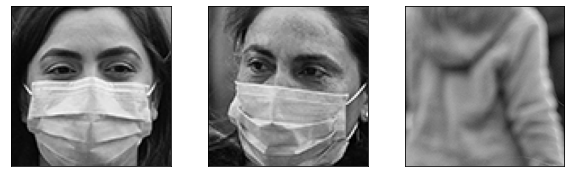

Com Mascara . Com Mascara . Com Mascara


In [205]:
vetores = processar_imagem(pca, classificador, 'corona-no-brasil-5-perguntas-site.png')
c = knn.predict(pca.transform(vetores))

print(*[classes[e] for e in c], sep= " . ")

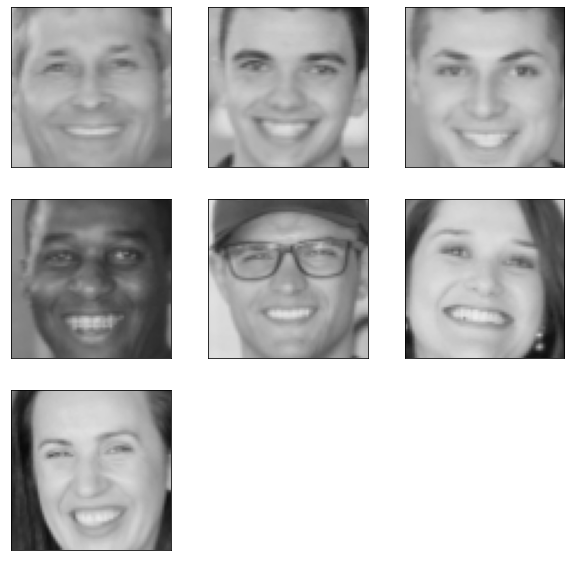

Com Mascara . Com Mascara . Com Mascara . Com Mascara . Com Mascara . Com Mascara . Com Mascara


In [210]:
vetores = processar_imagem(pca, classificador, 'sdfsd.jpg')
c = knn.predict(pca.transform(vetores))

print(*[classes[e] for e in c], sep= " . ")